### "What just happened???"

Here we take an existing modflow model and setup a very complex parameterization system for arrays and boundary conditions.  All parameters are setup as multpliers: the original inputs from the modflow model are saved in separate files and during the forward run, they are multplied by the parameters to form new model inputs.  the forward run script ("forward_run.py") is also written.  And somewhat meaningful prior covariance matrix is constructed from geostatistical structures with out any additional arguements...oh yeah!

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/flopy/flopy


In [2]:
nam_file = "freyberg.nam"
org_model_ws = "Freyberg_sfr_update"
temp_model_ws = "temp"
new_model_ws = "template"
# load the model, change dir and run once just to make sure everthing is working
m = flopy.modflow.Modflow.load(nam_file,model_ws=org_model_ws,check=False, exe_name="mfnwt",
                              forgive=False,verbose=True)
m.change_model_ws(temp_model_ws,reset_external=True)
m.write_input()
try:
    m.run_model()
except():
    pass


Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> Freyberg_sfr_update/freyberg.nam

--------------------------------------------------
External unit dictionary:
OrderedDict([(2, filename:Freyberg_sfr_update/freyberg.list, filetype:LIST), (11, filename:Freyberg_sfr_update/freyberg.dis, filetype:DIS), (13, filename:Freyberg_sfr_update/freyberg.bas, filetype:BAS6), (31, filename:Freyberg_sfr_update/freyberg.upw, filetype:UPW), (19, filename:Freyberg_sfr_update/freyberg.rch, filetype:RCH), (32, filename:Freyberg_sfr_update/freyberg.nwt, filetype:NWT), (14, filename:Freyberg_sfr_update/freyberg.oc, filetype:OC), (30, filename:Freyberg_sfr_update/freyberg.lmt6, filetype:LMT6), (20, filename:Freyberg_sfr_update/freyberg.wel, filetype:WEL), (17, filename:Freyberg_sfr_update/freyberg.sfr, filetype:SFR), (50, filename:Freyberg_sfr_update/freyberg.cbc, filetype:DATA(BINARY)), (51, filename:Freyberg_sfr_update/freyberg.hds, filetyp

You want some pilot points? We got that...how about one set of recharge multiplier pilot points applied to all stress periods? and sy in layer 1?

In [5]:
m.get_package_list()

['DIS', 'BAS6', 'UPW', 'RCH', 'NWT', 'OC', 'LMT6', 'WEL', 'SFR']

## Parameterization

In [3]:
pp_props = [["upw.sy",0], ["rch.rech",None]]

You want some constants (uniform value multipliers)?  We got that too....

In [4]:
const_props = []
for iper in range(m.nper): # recharge for past and future
    const_props.append(["rch.rech",iper])
for k in range(m.nlay):
    const_props.append(["upw.hk",k])
    const_props.append(["upw.ss",k])


You want grid-scale parameter flexibility for hk in all layers? We got that too...and how about sy in layer 1 and vka in layer 2 while we are at it

In [5]:
grid_props = [["upw.sy",0],["upw.vka",1]]
for k in range(m.nlay):
    grid_props.append(["upw.hk",k])
    

Some people like using zones...so we have those too

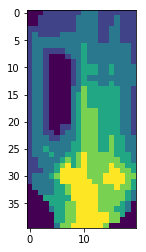

In [6]:
zn_array = np.loadtxt(os.path.join("Freyberg_truth","hk.zones"))
plt.imshow(zn_array)

In [7]:
zone_props = [["upw.ss",0], ["rch.rech",0],["rch.rech",1]]
k_zone_dict = {k:zn_array for k in range(m.nlay)}


But wait, boundary conditions are uncertain too...Can we add some parameter to represent that uncertainty?  You know it!

In [8]:
bc_props = []
for iper in range(m.nper):
    bc_props.append(["wel.flux",iper])

## Observations

Since observations are "free", we can carry lots of them around...

In [9]:
# here were are building a list of stress period, layer pairs (zero-based) that we will use
# to setup obserations from every active model cell for a given pair
hds_kperk = []
for iper in range(m.nper):
    for k in range(m.nlay):
        hds_kperk.append([iper,k])

## Here it goes...
Now we will use all these args to construct a complete PEST interface - template files, instruction files, control file and even the forward run script!  All parameters are setup as multiplers against the existing inputs in the modflow model - the existing inputs are extracted (with flopy) and saved in a sub directory for safe keep and for multiplying against during a forward model run.  The constructor will also write a full (covariates included) prior parameter covariance matrix, which is needed for all sorts of important analyses.|

In [11]:
mfp_boss = pyemu.helpers.PstFromFlopyModel(nam_file,new_model_ws,org_model_ws=temp_model_ws,
                                          pp_props=pp_props,spatial_list_props=bc_props,
                                          zone_props=zone_props,grid_props=grid_props,
                                          const_props=const_props,k_zone_dict=k_zone_dict,
                                          remove_existing=True,pp_space=4,sfr_pars=True,
                                          sfr_obs=True,hds_kperk=hds_kperk)

2019-03-30 08:14:28.581408 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp/freyberg.nam

--------------------------------------------------
External unit dictionary:
OrderedDict([(2, filename:temp/freyberg.list, filetype:LIST), (11, filename:temp/freyberg.dis, filetype:DIS), (13, filename:temp/freyberg.bas, filetype:BAS6), (31, filename:temp/freyberg.upw, filetype:UPW), (19, filename:temp/freyberg.rch, filetype:RCH), (32, filename:temp/freyberg.nwt, filetype:NWT), (14, filename:temp/freyberg.oc, filetype:OC), (30, filename:temp/freyberg.lmt6, filetype:LMT6), (20, filename:temp/freyberg.wel, filetype:WEL), (17, filename:temp/freyberg.sfr, filetype:SFR), (50, filename:temp/freyberg.cbc, filetype:DATA(BINARY)), (51, filename:temp/freyberg.hds, filetype:DATA(BINARY)), (60, filename:temp/freyberg.sfr.out, filetype:DATA)])
--------------------------------------------------

ModflowBas6 fre

2019-03-30 08:14:30.669257 64 pilot point parameters created
2019-03-30 08:14:30.670144 pilot point 'pargp':sy0,rech0
2019-03-30 08:14:30.670569 finished: calling setup_pilot_point_grid() took: 0:00:00.170876
2019-03-30 08:14:30.673288 starting: calculating factors for p=sy0, k=0
2019-03-30 08:14:30.674299 saving krige variance file:template/pp_k0_general_zn.fac
2019-03-30 08:14:30.674585 saving krige factors file:template/pp_k0_general_zn.fac
starting interp point loop for 800 points
took 2.854368 seconds
2019-03-30 08:14:33.581245 finished: calculating factors for p=sy0, k=0 took: 0:00:02.907957
2019-03-30 08:14:33.582100 starting: calculating factors for p=rech0, k=0
2019-03-30 08:14:33.582835 finished: calculating factors for p=rech0, k=0 took: 0:00:00.000735
2019-03-30 08:14:33.583258 starting: processing pp_prefix:rech0
2019-03-30 08:14:33.596339 starting: processing pp_prefix:sy0
2019-03-30 08:14:33.627107 finished: setting up pilot point process took: 0:00:03.130374
2019-03-30 

2019-03-30 08:14:39.211963 saving prior covariance matrix to file template/freyberg.pst.prior.cov
2019-03-30 08:14:43.290101 finished: building prior covariance matrix took: 0:00:05.487778
2019-03-30 08:14:43.290877 starting: saving intermediate _setup_<> dfs into template
2019-03-30 08:14:43.366570 finished: saving intermediate _setup_<> dfs into template took: 0:00:00.075693
2019-03-30 08:14:43.367105 all done


The ``mpf_boss`` instance containts a ``pyemu.Pst`` object (its already been saved to a file, but you may want to manipulate it more)

In [12]:
pst = mfp_boss.pst

In [13]:
pst.npar,pst.nobs

(3612, 6633)

That was crazy easy - this used to take me weeks to get a PEST interface setup with level of complexity

In [14]:
pst.template_files

['wel.csv.tpl',
 'sy1.dat_gr.tpl',
 'vka0.dat_gr.tpl',
 'hk0.dat_gr.tpl',
 'hk1.dat_gr.tpl',
 'hk2.dat_gr.tpl',
 'ss0.dat_zn.tpl',
 'rech1.dat_zn.tpl',
 'rech2.dat_zn.tpl',
 'rech3.dat_cn.tpl',
 'rech4.dat_cn.tpl',
 'rech5.dat_cn.tpl',
 'hk3.dat_cn.tpl',
 'ss1.dat_cn.tpl',
 'hk4.dat_cn.tpl',
 'ss2.dat_cn.tpl',
 'hk5.dat_cn.tpl',
 'ss3.dat_cn.tpl',
 'sfr_seg_pars.dat.tpl',
 'sy0pp.dat.tpl',
 'rech0pp.dat.tpl']

In [15]:
pst.instruction_files

['freyberg.hds.dat.ins',
 'vol.dat.ins',
 'freyberg.sfr.out.processed.ins',
 'flux.dat.ins']

Lets look at that important prior covariance matrix

In [16]:
cov = pyemu.Cov.from_ascii(os.path.join(new_model_ws,m.name+".pst.prior.cov"))

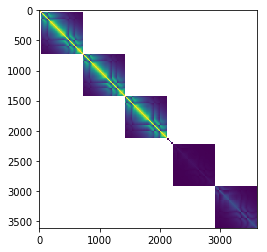

In [17]:
cov = cov.x
cov[cov==0] = np.NaN
plt.imshow(cov)

### adjusting parameter bounds
Let's say you don't like the parameter bounds in the new control file (note you can pass a par_bounds arg to the constructor).

In [18]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hcond1_0001,hcond1_0001,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0002,hcond1_0002,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0003,hcond1_0003,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0004,hcond1_0004,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0005,hcond1_0005,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0006,hcond1_0006,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0007,hcond1_0007,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0008,hcond1_0008,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0009,hcond1_0009,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0010,hcond1_0010,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1


Let's change the ``welflux`` pars

In [22]:
par = pst.parameter_data #get a ref to the parameter data dataframe
wpars = par.pargp=="welflux_k02"
par.loc[wpars]

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
wf0200090016,wf0200090016,log,factor,1.0,0.1,10.0,welflux_k02,1.0,0.0,1
wf0200110013,wf0200110013,log,factor,1.0,0.1,10.0,welflux_k02,1.0,0.0,1
wf0200200014,wf0200200014,log,factor,1.0,0.1,10.0,welflux_k02,1.0,0.0,1
wf0200260010,wf0200260010,log,factor,1.0,0.1,10.0,welflux_k02,1.0,0.0,1
wf0200290006,wf0200290006,log,factor,1.0,0.1,10.0,welflux_k02,1.0,0.0,1
wf0200340012,wf0200340012,log,factor,1.0,0.1,10.0,welflux_k02,1.0,0.0,1


In [23]:
par.loc[wpars,"parubnd"] = 1.1
par.loc[wpars,"parlbnd"] = 0.9
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hcond1_0001,hcond1_0001,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0002,hcond1_0002,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0003,hcond1_0003,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0004,hcond1_0004,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0005,hcond1_0005,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0006,hcond1_0006,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0007,hcond1_0007,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0008,hcond1_0008,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0009,hcond1_0009,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0010,hcond1_0010,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1


In [24]:
# now we need to rebuild the prior parameter covariance matrix
mfp_boss.build_prior()

2019-03-30 08:16:06.298360 starting: building prior covariance matrix
2019-03-30 08:16:06.318574 WARNING: geospatial prior not implemented for SFR pars
2019-03-30 08:16:07.470814 saving prior covariance matrix to file template/freyberg.pst.prior.cov
2019-03-30 08:16:11.723949 finished: building prior covariance matrix took: 0:00:05.425589


# Boom!